In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

In [0]:
def get_train_loader():
  batch_size = 64
  transforms_train = transforms.Compose(transforms.ToTensor())
  data_train = torchvision.datasets.MNIST(root='./data', train=True, 
                                        download=True, 
                                        transform=transforms.ToTensor())
  trainloader = torch.utils.data.DataLoader(data_train,batch_size = batch_size,shuffle = True)
  return trainloader

def get_test_loader():
  batch_size = 64
  transforms_test = transforms.Compose( transforms.ToTensor())
  data_test = torchvision.datasets.MNIST(root='./data', train=False, 
                                          download=True, 
                                          transform=transforms.ToTensor())
  testloader = torch.utils.data.DataLoader(data_test,batch_size = batch_size,shuffle = True)
  return testloader

device = torch.device('cuda:0')

In [0]:
class MNISTCNNModel(nn.Module):
    def __init__(self):
      torch.manual_seed(0)
      super(MNISTCNNModel, self).__init__()
      self.net = self.modify_fc(models.vgg16_bn(pretrained=True))
      self.net.to(device)
      
    def fit(self,trainloader,testloader,opt,loss_fn,epochs = 5):
      acc ={}
      for e in range(epochs):
        acc[e] = self.predict(testloader)
        self.net.train()
        for i,data in enumerate(trainloader,0):
          image,label = data
          image = image.to(device)
          label = label.to(device)
          opt.zero_grad()
          pred = self.forward(image)
          loss = loss_fn(pred,label)
          loss.backward()
          opt.step()
        print('end of epoch %d'%(e+1))
      plt.plot(acc.values())
      plt.show()
      print('Accuracy = %f'%acc[epochs-1])
        
    def predict(self,testloader):
        self.net.eval()
        success = 0
        total = 0
        images,labels = next(iter(testloader))
        labels = labels.to(device)
        pred = self.forward(images)
        for i in range(pred.shape[0]):
          total+=1
          if(pred.argmax(-1)[i]==labels[i]):
            success +=1
        return (success/total)
      
    def forward(self, X):
      return self.net(self.make_color(X))
    
    def make_color(self,images):
      newbatch = torch.zeros(images.shape[0],3,images.shape[2],images.shape[3])
      for i in range(images.shape[0]):
        newbatch[i][0] = images[i][0]
        newbatch[i][1] = images[i][0]
        newbatch[i][2] = images[i][0]
      newbatch = newbatch.to(device)
      return newbatch
    
    def modify_fc(self,model):
      for param in model.features.parameters():
        param.require_grad = False
      num_in_features = model.classifier[6].in_features
      mod_classifier = list(model.classifier.children())[:-1]
      mod_classifier.extend([nn.Linear(num_in_features,10)])
      model.classifier = nn.Sequential(*mod_classifier)
      model = model.to(device)
      return model
      
    def get_params(self):
      return self.net.parameters()


In [0]:
def driver_mnistcnn():
  mnistnet = MNISTCNNModel()
  loss_fn = nn.CrossEntropyLoss()
  opt = optim.SGD(mnistnet.get_params(),lr=0.01)
  mnistnet.fit(get_train_loader(),get_test_loader(),opt,loss_fn)
  


end of epoch 1
end of epoch 2
end of epoch 3
end of epoch 4
end of epoch 5


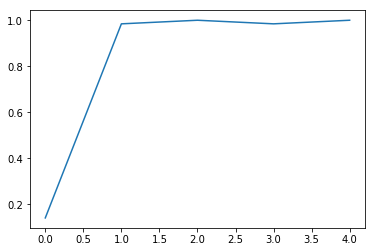

Accuracy = 1.000000


In [61]:
driver_mnistcnn()